# Laboratorium 9. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o odpalaniu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania zadań domowych.

In [ ]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Extracting ./cifar-10-python.tar.gz to .

CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


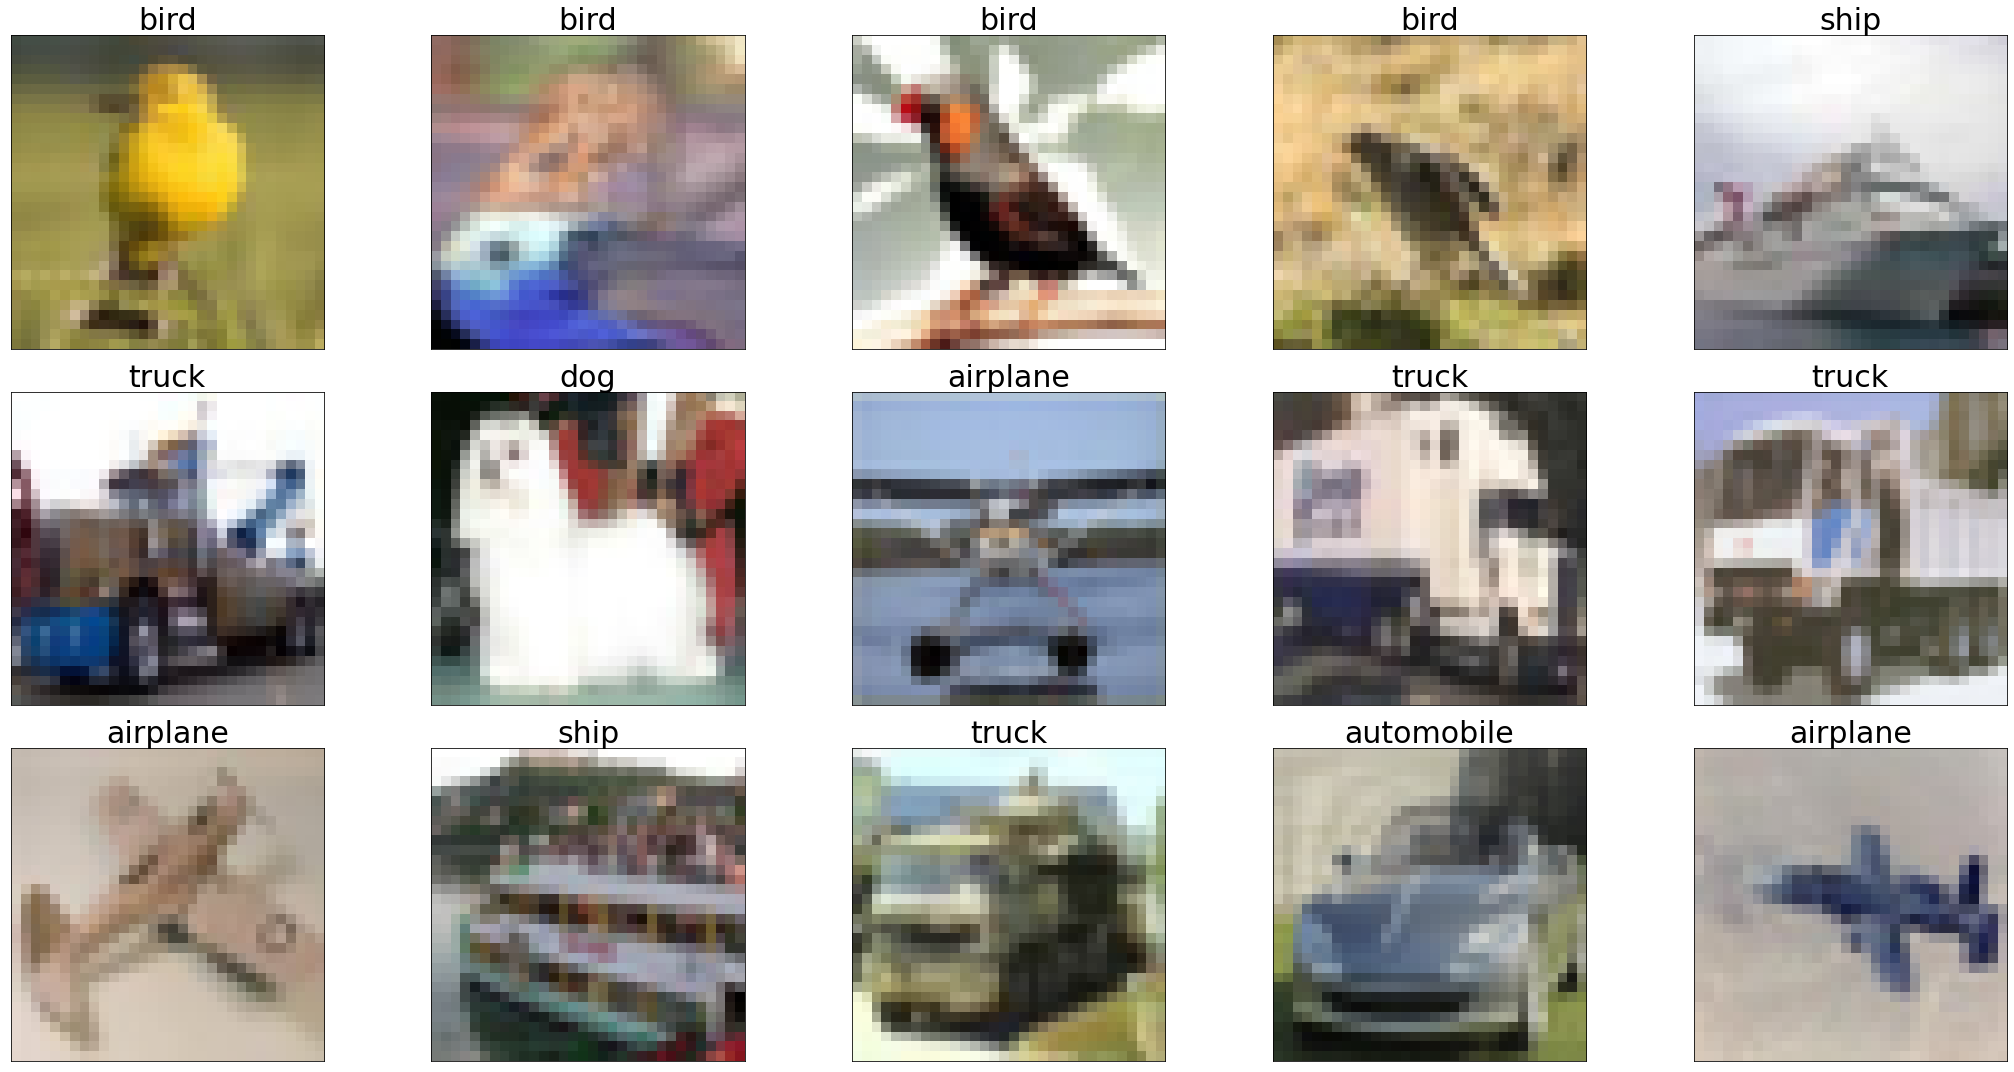

In [ ]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# preapre visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [ ]:
# tutaj zdefiniuj swój model, nie zapomnij podziedziczyć po torch.nn.Module

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# sequential = nn.Sequential(
#       nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
#     , nn.ReLU()
#     , nn.MaxPool2d(kernel_size=2, stride=2)
#     , nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
#     , nn.ReLU()
#     , nn.MaxPool2d(kernel_size=2, stride=2)
#     , nn.Flatten(start_dim=1)  
#     , nn.Linear(in_features=12*4*4, out_features=120)
#     , nn.ReLU()
#     , nn.Linear(in_features=120, out_features=60)
#     , nn.ReLU()
#     , nn.Linear(in_features=60, out_features=10)
# )

input_size = 3*32*32
output_size = 10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop_layer = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 72)
        self.fc4 = nn.Linear(72, 64)
        self.fc5 = nn.Linear(64, 48)
        self.fc6 = nn.Linear(48, 32)
        self.fc7 = nn.Linear(32, 10)

    def forward(self, x):
        self.drop_layer
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x)), 2))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x)), 2))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x
    # def wykres(self):


net = Net()


In [ ]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([ToTensor()]))


test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=Compose([ToTensor()]))

# Definiowanie danych treningowych, testowych i walidacyjnych

# torch.manual_seed(43)
# val_size = 5000
# train_size = len(train_dataset) - val_size

# train_ds, val_ds = random_split(dataset, [train_size, val_size])
# len(train_ds), len(val_ds)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)
# val_loader = DataLoader(val_ds, batch_size=200, num_workers=4)

classes = dataset.classes # list of labels

# print(len(train_loader), len(test_loader), len(val_loader))
# print(len(train_loader), len(test_loader))
# print(train_dataset[1][0].Size, test_dataset[1][0].Size) #AttributeError: 'Tensor' object has no attribute 'Size'

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # def loss func
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # def optimizer
epoch = 20
# TRAINING
loss_data = []
for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data # get the inputs; data is a list of [inputs, labels]

        optimizer.zero_grad() # zero the parameter gradients

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) # loss counting
        loss.backward() # same
        optimizer.step()

        # print statistics
        
        running_loss += loss.item()
        
        if i % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_data.append(running_loss)
            running_loss = 0.0
            


print('Finished Training')





[1,     1] loss: 0.00049
[2,     1] loss: 0.00055
[3,     1] loss: 0.00051
[4,     1] loss: 0.00048
[5,     1] loss: 0.00041
[6,     1] loss: 0.00049
[7,     1] loss: 0.00041
[8,     1] loss: 0.00028
[9,     1] loss: 0.00044
[10,     1] loss: 0.00035
[11,     1] loss: 0.00033
[12,     1] loss: 0.00039
[13,     1] loss: 0.00031
[14,     1] loss: 0.00023
[15,     1] loss: 0.00027
[16,     1] loss: 0.00031
[17,     1] loss: 0.00029
[18,     1] loss: 0.00024
[19,     1] loss: 0.00020
[20,     1] loss: 0.00025
Finished Training


In [ ]:
# CHECK
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))




Accuracy of the network on the 10000 test images: 64 %


In [ ]:
# VALIDATION
# lr = []
# momentum = []
# batch_size = []

net_val = Net()

# hparams
batch_size = 100
lr=0.01

# VAL_SET
torch.manual_seed(43)
val_size = 5000
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) 

best_hparams = None
best_loss = None


epoch = 2
criterion = nn.CrossEntropyLoss() # def loss func
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9) # def optimizer

for epoch in range(epoch):  # loop over the dataset multiple times
    for batch_size in [10, 50, 100, 200, 1000]:
        val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=4)
        for lr in [1e-8, 1e-7, 1e-6, 1e-5, 1e-3, 1e-2]:
           # for momentum in []
           optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
           running_loss = 0.0
        
           for i, data in enumerate(val_loader, 0):
            
               inputs, labels = data # get the inputs; data is a list of [inputs, labels]
               optimizer.zero_grad() # zero the parameter gradients

              # forward + backward + optimize
               outputs = net_val(inputs)
               loss_val = criterion(outputs, labels) # loss counting
               loss_val.backward() # same
               optimizer.step()
                  
               running_loss += loss.item()
               running_loss = 0.0
              
               if best_hparams is None or loss_val < best_loss:
                   best_hparams = (lr, batch_size)
                   best_loss = loss_val
               if i % 2000 == 0:    # print every 2000 mini-batches
                  print(f"{epoch+1} Validation loss for lr={lr}, batch_size={batch_size}: {loss_val}")
# batch_size = 10 najlepszy :)
# lr = nie ma znazcenia :(

1 Validation loss for lr=1e-08, batch_size=10: 2.2722573280334473
1 Validation loss for lr=1e-07, batch_size=10: 2.2722573280334473
1 Validation loss for lr=1e-06, batch_size=10: 2.2722573280334473
1 Validation loss for lr=1e-05, batch_size=10: 2.2722573280334473
1 Validation loss for lr=0.001, batch_size=10: 2.2722573280334473
1 Validation loss for lr=0.01, batch_size=10: 2.2722573280334473
1 Validation loss for lr=1e-08, batch_size=50: 2.2969751358032227
1 Validation loss for lr=1e-07, batch_size=50: 2.2969751358032227
1 Validation loss for lr=1e-06, batch_size=50: 2.2969751358032227
1 Validation loss for lr=1e-05, batch_size=50: 2.2969751358032227
1 Validation loss for lr=0.001, batch_size=50: 2.2969751358032227
1 Validation loss for lr=0.01, batch_size=50: 2.2969751358032227
1 Validation loss for lr=1e-08, batch_size=100: 2.3052124977111816
1 Validation loss for lr=1e-07, batch_size=100: 2.3052124977111816
1 Validation loss for lr=1e-06, batch_size=100: 2.3052124977111816
1 Validat

In [ ]:
# LOSS ON TEST_DATA

criterion = nn.CrossEntropyLoss() # def loss func
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # def optimizer
epoch = 20
# TRAINING
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=4) # batch_seze = 10 bo ak wyszło z walidacji :)
loss_data2 = []
for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(test_loader, 0):
        
        inputs, labels = data # get the inputs; data is a list of [inputs, labels]

        optimizer.zero_grad() # zero the parameter gradients

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) # loss counting
        loss.backward() # same
        optimizer.step()

        # print statistics
        
        running_loss += loss.item()
        
        if i % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 50))
            loss_data2.append(running_loss)
            running_loss = 0.0
            


print('Finished Testining')



[1,     1] loss: 0.02037
[2,     1] loss: 0.03771
[3,     1] loss: 0.00962
[4,     1] loss: 0.00286
[5,     1] loss: 0.00286
[6,     1] loss: 0.01820
[7,     1] loss: 0.01177
[8,     1] loss: 0.00505
[9,     1] loss: 0.01218
[10,     1] loss: 0.00512
[11,     1] loss: 0.00165
[12,     1] loss: 0.00432
[13,     1] loss: 0.00146
[14,     1] loss: 0.00533
[15,     1] loss: 0.03508
[16,     1] loss: 0.01375
[17,     1] loss: 0.00181
[18,     1] loss: 0.00268
[19,     1] loss: 0.00514
[20,     1] loss: 0.00777
Finished Testining


In [ ]:
# CHECK
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


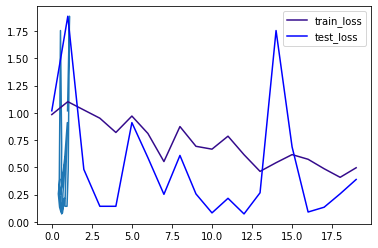

In [ ]:
plt.plot(loss_data, loss_data2)
plt.plot(range(len(loss_data)), loss_data, label='train_loss', color = '#340B8C')
plt.plot(range(len(loss_data2)), loss_data2, label='test_loss', color = 'b')
plt.legend(loc='best')
plt.show()
# print(len(loss_data))
# print(len(loss_data2))

## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

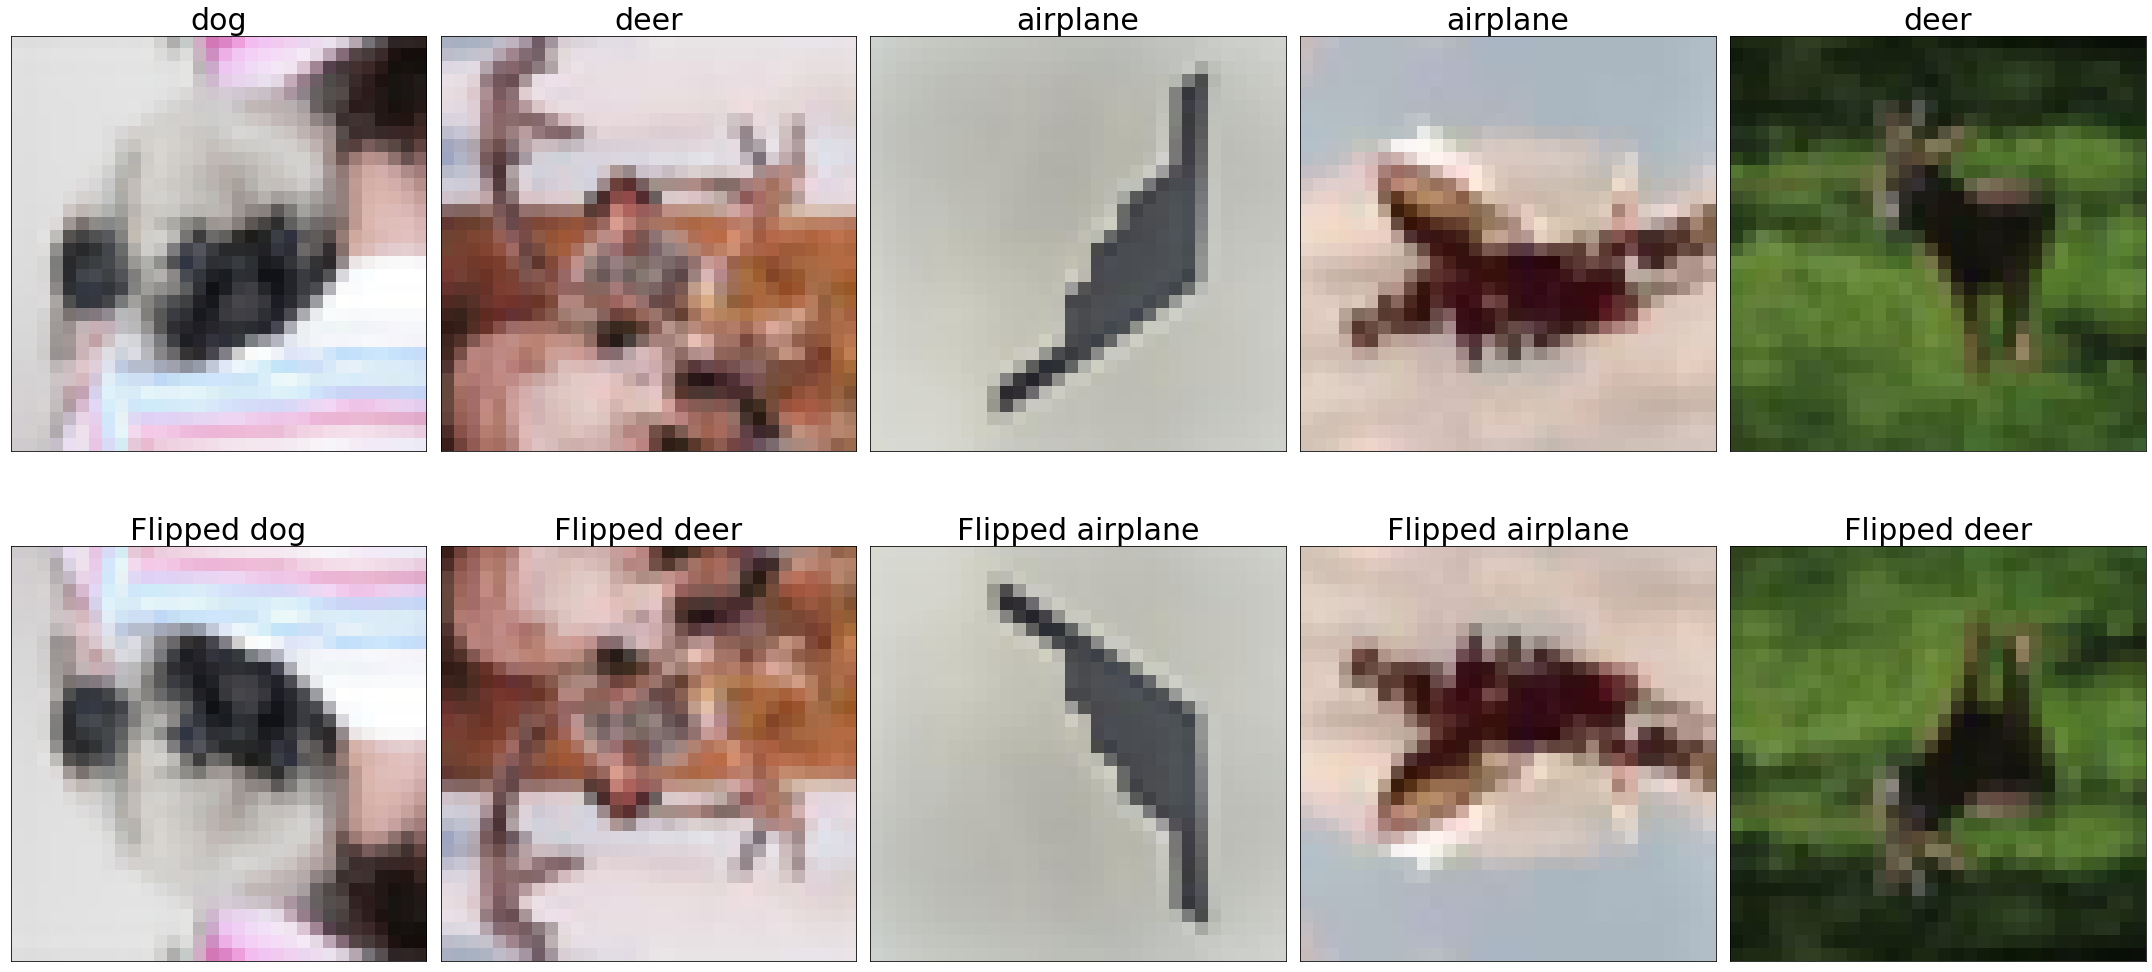

In [ ]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [ ]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe

train_transform = Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

test_transform = Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=train_transform)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=test_transform)


train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
criterion = nn.CrossEntropyLoss() # def loss func
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # def optimizer
epoch = 20
# TRAINING
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=4) # batch_seze = 10 bo ak wyszło z walidacji :)
loss_data2 = []
for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(test_loader, 0):
        
        inputs, labels = data # get the inputs; data is a list of [inputs, labels]

        optimizer.zero_grad() # zero the parameter gradients

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) # loss counting
        loss.backward() # same
        optimizer.step()

        # print statistics
        
        running_loss += loss.item()
        
        if i % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 50))
            loss_data2.append(running_loss)
            running_loss = 0.0
            


print('Finished Testining')

[1,     1] loss: 0.00432
[2,     1] loss: 0.00802
[3,     1] loss: 0.00367
[4,     1] loss: 0.00944
[5,     1] loss: 0.00130
[6,     1] loss: 0.01820
[7,     1] loss: 0.00857
[8,     1] loss: 0.02503
[9,     1] loss: 0.02387
[10,     1] loss: 0.04409
[11,     1] loss: 0.04601
[12,     1] loss: 0.04599
[13,     1] loss: 0.04601
[14,     1] loss: 0.04601
[15,     1] loss: 0.04601
[16,     1] loss: 0.04601
[17,     1] loss: 0.04601
[18,     1] loss: 0.04601
[19,     1] loss: 0.04601
[20,     1] loss: 0.04601
Finished Testining


Accuracy of the network on the 10000 test images: 10 %


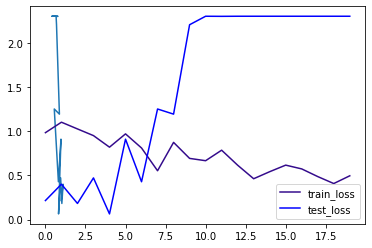

In [ ]:
# CHECK
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# plt.plot(loss_data, loss_data2)
# plt.plot(range(len(loss_data)), loss_data, label='train_loss', color = '#340B8C')
# plt.plot(range(len(loss_data2)), loss_data2, label='test_loss', color = 'b')
# plt.legend(loc='best')
# plt.show()
# print(len(loss_data))
# print(len(loss_data2))

## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci aby uzyskać błędne, a nawet specyficzne, wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \space \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [ ]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [ ]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2020-21/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


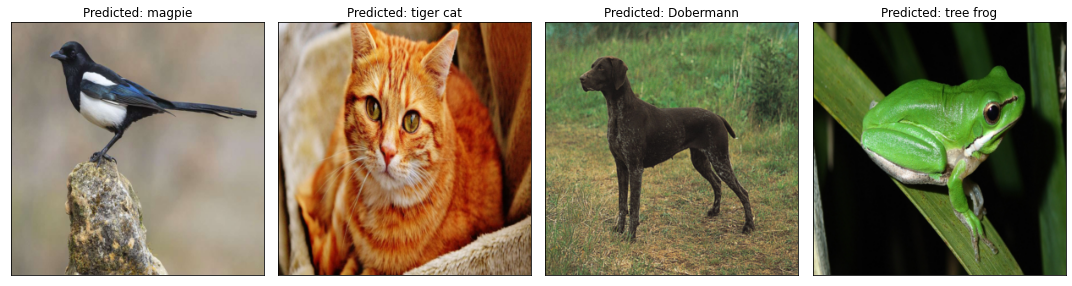

In [ ]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [ ]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign() #WZÓR WYRZEJ
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

In [ ]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizacje znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji 

In [54]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizacje!

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# load some data
for x, y in loader:
    break


In [56]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych

# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
model = Net()
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign() #WZÓR WYRZEJ
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

# print(len(adv_imgs[0][0][0]))

RuntimeError: ignored

In [57]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu

model = Net()

# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

RuntimeError: ignored